<style>
div.cell, div.text_cell_render{
  max-width:750px;
  margin-left:auto;
  margin-right:auto;
}

.rendered_html
{
  font-size: 140%;
  }

.rendered_html li
{
  line-height: 1.8;
  }

.rendered_html h1, h2 {
  text-align:center;
  font-familly:"Charis SIL", serif;
}

.input_prompt, .CodeMirror-lines, .output_area
{
  font-family: Consolas;
  font-size: 110%;
  }
</style>

<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for UW's [Astro 599](http://www.astro.washington.edu/users/vanderplas/Astr599/) course. Source and license info is on [GitHub](https://github.com/jakevdp/2013_fall_ASTR599/).</i></small>

# Efficient Numerical Computing with Numpy

In this session, we'll discuss how to make your programs as efficient as possible, mainly by taking advantage of *vectorization* in NumPy.

## Aside: the "Unladen Swallow"

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("y2R3FvS4xr4")

That video was the original reference behind the now-defunct [unladen swallow](http://en.wikipedia.org/wiki/Unladen_Swallow) project, which had the goal of making Python's C implementation faster.

Yes, Python is (unfortunately) a rather slow language.

Here is an example:

In [1]:
# A silly function implemented in Python

def func_python(N): 
    d = 0.0
    for i in range(N):
        d += (i % 3 - 1) * i
    return d

In [2]:
# Use IPython timeit magic to time the execution
%timeit func_python(10000)

1000 loops, best of 3: 1.59 ms per loop


To compare to a compiled language, let's write the same function in fortran and use the ``f2py`` tool (included in NumPy) to compile it

In [5]:
%%file func_fortran.f

      subroutine func_fort(n, d)
           integer, intent(in) :: n
           double precision, intent(out) :: d
           integer :: i
           d = 0
           do i = 0, n - 1
                d = d + (mod(i, 3) - 1) * i
           end do
      end subroutine func_fort


Overwriting func_fortran.f


In [5]:
!f2py -c func_fortran.f -m func_fortran > /dev/null  #f2py is a nice tool

IOError: [Errno 2] No such file or directory: 'func_fortran.f'. Skipping file "func_fortran.f".
error: f2py target file '/var/folders/3y/w606ww152410_h2s36zpxtr80000gn/T/tmpQIAedm/src.macosx-10.11-x86_64-2.7/func_fortranmodule.c' not generated


In [6]:
from func_fortran import func_fort
%timeit func_fort(10000)

ImportError: No module named func_fortran

Fortran is about 100 times faster for this task!

## Why is Python so slow?

We alluded to this yesterday, but languages tend to have a compromise between convenience and performance.

- <font color="green">C, Fortran, etc.</font>: **static typing** and **compiled code** leads to fast execution

    + But: lots of development overhead in declaring variables, no interactive prompt, etc.

- <font color="red">Python, R, Matlab, IDL, etc.</font>: **dynamic typing** and **interpreted excecution** leads to fast development

    + But: lots of execution overhead in dynamic type-checking, etc.
    
We like Python because our **development time** is generally more valuable than **execution time**.  But sometimes speed can be an issue.

## Strategies for making Python fast

1. Use Numpy **ufuncs** to your advantage

2. Use Numpy **aggregates** to your advantage

3. Use Numpy **broadcasting** to your advantage

4. Use Numpy **slicing and masking** to your advantage

5. Use a tool like *SWIG*, *cython* or *f2py* to interface to compiled code.

Here we'll cover the first four, and leave the fifth strategy for a later session.

## Strategy 1: Using UFuncs in Numpy

A **ufunc** in numpy is a *Universal Function*.  This is a function which operates element-wise on an array.  We've already seen examples of these in the various arithmetic operations:

In [7]:
import numpy as np
x = np.random.random(4)
print x
print x + 1  # add 1 to each element of x

[ 0.17990409  0.19374194  0.67406277  0.15762164]
[ 1.17990409  1.19374194  1.67406277  1.15762164]


In [9]:
print x * 2  # multiply each element of x by 2

[ 1.81678346  1.32294159  1.49214734  1.32228771]


In [10]:
print x * x  # multiply each element of x by itself

[ 0.82517553  0.43754362  0.55662592  0.43711119]


In [8]:
print x[1:] - x[:-1]

[ 0.01383784  0.48032083 -0.51644113]


These are *binary ufuncs*: they take two arguments.

There are also many *unary ufuncs:*

In [9]:
-x

array([-0.17990409, -0.19374194, -0.67406277, -0.15762164])

In [10]:
np.sin(x)

array([ 0.17893521,  0.19253216,  0.62416534,  0.15696978])

### The Speed of Ufuncs

In [14]:
x = np.random.random(10000)

In [13]:
%%timeit   #times the corresponding cell of ipython notebook 
# compute element-wise x + 1 via a ufunc 
y = np.zeros_like(x)
y = x + 1

The slowest run took 8.07 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.08 µs per loop


In [14]:
%%timeit
# compute element-wise x + 1 via a loop
y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = x[i] + 1

The slowest run took 6.59 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.71 µs per loop


In [17]:
np.zeros_like   #V.V. useful, you do not need to go to the size of the new array

<function numpy.core.numeric.zeros_like>

#### Why is NumPy so much faster?

Numpy UFuncs are faster than Python functions involving loops, because *the looping happens in compiled code*.  This is only possible when types are known beforehand, which is why numpy arrays must be typed.

### Other Available Ufuncs

- Trigonometric functions (``np.sin``, ``np.cos``, etc.)
- Scipy special functions (``scipy.special.j0``, ``scipy.special.gammaln``, etc.)
- Element-wise minimum/maximum (``np.minimum``, ``np.maximum``)
- User-defined ufuncs (read more [here](http://scipy-lectures.github.io/advanced/advanced_numpy/#universal-functions))

In [19]:
x = np.random.random(5)
y = np.random.random(5)
print x
print y
print np.minimum(x, y)
print np.maximum(x, y)

[ 0.62459803  0.84185619  0.49414511  0.00463438  0.35469858]
[ 0.33039625  0.55327746  0.22341168  0.69148112  0.44113723]
[ 0.33039625  0.55327746  0.22341168  0.00463438  0.35469858]
[ 0.62459803  0.84185619  0.49414511  0.69148112  0.44113723]


In [21]:
# contrast this behavior with that of min() and max()
print np.min(x)  #returns the min in that array, min vs minimum 
print np.max(x)

0.00463437940796
0.841856186453


In [22]:
%matplotlib inline
# On older IPython versions, use %pylab inline
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


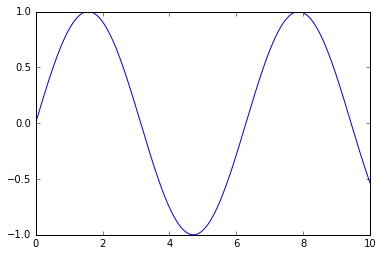

In [23]:
x = np.linspace(0, 10, 1000)
plt.plot(x, np.sin(x))

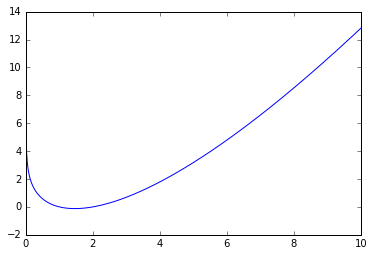

In [24]:
from scipy.special import gammaln
plt.plot(x, gammaln(x))

### Some interesting properties of UFuncs

UFuncs have some methods built-in, which allow for some very interesting, flexible, and fast operations:
UFuncs have methods like accummulate and outer !!!

In [30]:
x = np.arange(5)
y = np.arange(1, 6)
np.add(x, y)

array([1, 3, 5, 7, 9])

In [34]:
np.add.accumulate(x)   #to get cummulative functions, much much faster than writing code

array([ 0,  1,  3,  6, 10])

In [32]:
np.multiply.accumulate(x)

array([0, 0, 0, 0, 0])

In [33]:
np.multiply.accumulate(y)

array([  1,   2,   6,  24, 120])

In [45]:
np.add.identity   #static data-type used to represent the identity element in the accummulate function

0

In [46]:
np.multiply.identity

1

In [48]:
np.add.outer(x, y)  #returns a multi dimensional array

array([[1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8],
       [5, 6, 7, 8, 9]])

In [51]:
np.multiply.outer(x,y)  #v.v. efficient in forming grids , maybe can be evaluated with itertools to generate them lazily

array([[ 0,  0,  0,  0,  0],
       [ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20]])

In [29]:
# make a times-table
x = np.arange(1, 13)
print np.multiply.outer(x, x)

[[  1   2   3   4   5   6   7   8   9  10  11  12]
 [  2   4   6   8  10  12  14  16  18  20  22  24]
 [  3   6   9  12  15  18  21  24  27  30  33  36]
 [  4   8  12  16  20  24  28  32  36  40  44  48]
 [  5  10  15  20  25  30  35  40  45  50  55  60]
 [  6  12  18  24  30  36  42  48  54  60  66  72]
 [  7  14  21  28  35  42  49  56  63  70  77  84]
 [  8  16  24  32  40  48  56  64  72  80  88  96]
 [  9  18  27  36  45  54  63  72  81  90  99 108]
 [ 10  20  30  40  50  60  70  80  90 100 110 120]
 [ 11  22  33  44  55  66  77  88  99 110 121 132]
 [ 12  24  36  48  60  72  84  96 108 120 132 144]]


### UFunc mini-exercises

Each of the following functions take an array as input, and return an array as output.  They are implemented using loops, which is not very efficient.

1. For each function, implement a fast version which uses ufuncs to calculate the result more efficiently.  Double-check that you get the same result for several different arrays.

2. use the %timeit magic to time the execution of the two implementations for a large array (say, 1000 elements).  

In [30]:
# 1. computing the element-wise sine + cosine

from math import sin, cos
def slow_sincos(x):
    """x is a 1-dimensional array"""
    y = np.zeros_like(x)
    for i in range(len(x)):
        y[i] = sin(x[i]) + cos(x[i])
    return y

x = np.random.random(5)
print slow_sincos(x)

[ 1.41379464  1.24311597  1.39711558  1.1674103   1.41168674]


In [52]:
# write a fast_sincos function
def fast_sincos(x):
    return np.sin(x) + np.cos(x)

In [55]:
# 2. computing the difference between adjacent squares

def slow_sqdiff(x):
    """x is a 1-dimensional array"""
    y = np.zeros(len(x) - 1)
    for i in range(len(y)):
        y[i] = x[i + 1] ** 2 - x[i] ** 2
    return y

x = np.random.random(5)
print slow_sqdiff(x)

[-0.34692631 -0.4071973  -0.04844841  0.04076136]


In [54]:
# write a fast_sqdiff function
def fast_sqdiff(x):
    return x[1:]**2 - x[:-1]**2

In [57]:
print slow_sqdiff(np.arange(5)) 
print fast_sqdiff(np.arange(5))

[ 1.  3.  5.  7.]
[1 3 5 7]


In [58]:
# 3. computing the outer-product of each consecutive pair

def slow_pairprod(x):
    """x is a 1-dimensional array"""
    if len(x) % 2 != 0:
        raise ValueError("length of x must be even")
    N = len(x) / 2
    y = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            y[i, j] = x[2 * i] * x[2 * j + 1] 
    return y

x = np.arange(1, 9)
print slow_pairprod(x)

[[  2.   4.   6.   8.]
 [  6.  12.  18.  24.]
 [ 10.  20.  30.  40.]
 [ 14.  28.  42.  56.]]


In [35]:
# write a fast_pairprod function
def fast_pairprod(x):
    

## Strategy 2. Using Numpy Aggregates

Aggregates are functions over arrays which return smaller arrays.

Numpy has several built-in

In [36]:
# 10 x 10 array drawn from a standard normal
x = np.random.randn(10, 10)

In [37]:
print x.mean()

0.00323045925586


In [38]:
print np.mean(x)

0.00323045925586


In [39]:
print x.std()

1.0801379167


In [40]:
print x.var()

1.1666979191


In [41]:
print x.sum()

0.323045925586


In [42]:
print x.prod()

-5.72610473992e-23


In [43]:
print np.median(x)

0.00389134929792


In [44]:
print np.percentile(x, 50)

0.00389134929792


In [45]:
print np.percentile(x, (25, 75))

[-0.78582974895964608, 0.7374780554465159]


### Aggregates along certain dimensions

In [46]:
x = np.random.rand(3, 5)
print x

[[ 0.20461757  0.63148584  0.87816143  0.60442118  0.79228768]
 [ 0.40654761  0.97038926  0.96468488  0.27046867  0.17623957]
 [ 0.08734478  0.38353736  0.16706956  0.17744179  0.14886722]]


In [47]:
print x.sum(0)  # sum along rows

[ 0.69850996  1.98541246  2.00991587  1.05233165  1.11739447]


In [48]:
print x.sum(1)  # sum along columns

[ 3.11097371  2.78832999  0.96426071]


In [49]:
print np.median(x, 1)

[ 0.63148584  0.40654761  0.16706956]


In [50]:
print np.mean(x, 1)

[ 0.62219474  0.557666    0.19285214]


### Binary ufuncs as aggregates

Any binary ufunc (a ufunc taking two arguments) can be turned into an aggregate using the ``reduce()`` method:

In [51]:
np.sum(x, 1)

array([ 3.11097371,  2.78832999,  0.96426071])

In [52]:
np.add.reduce(x, 1)

array([ 3.11097371,  2.78832999,  0.96426071])

In [53]:
np.prod(x, 1)

array([ 0.05433798,  0.01814108,  0.00014784])

In [54]:
np.multiply.reduce(x, 1)

array([ 0.05433798,  0.01814108,  0.00014784])

In [55]:
np.divide.reduce(x, 1)

array([  0.77051726,   9.11086414,  51.60324064])

A caution: for ``reduce`` methods, the default axis is 0:

In [56]:
np.add.reduce(x)

array([ 0.69850996,  1.98541246,  2.00991587,  1.05233165,  1.11739447])

In [57]:
np.sum(x)

6.8635644110229004

### A quick efficiency note:
### Beware the built-in Python aggregates!

Python has a ``min``, ``max``, and ``sum`` aggregate built-in.  These are much more general than the versions in NumPy:

In [58]:
x = np.random.random(10000)

%timeit np.sum(x)
%timeit sum(x)

100000 loops, best of 3: 16.4 µs per loop
100 loops, best of 3: 4 ms per loop


**Dynamic type-checking is slow**.

Make sure to use Numpy's ``sum``, ``min``, and ``max``.

### Aggregate Mini-exercises

Take the following functions, and convert them into an efficient form using aggregates.  Each function expects a 1-dimensional array as input.  Double-check that your function returns the same result as the original

In [59]:
def slow_cubesum(x):
    """x is a 1D array"""
    result = 0
    for i in range(len(x)):
        result += x[i] ** 3
    return result

x = np.random.random(100)
print slow_cubesum(x)

28.3126613072


In [60]:
# implement fast_cubesum



In [61]:
def slow_rms(x):
    """x is a 1D array"""
    m = np.mean(x)
    rms = 0
    for i in range(len(x)):
        rms += (x[i] - m) ** 2
    rms /= len(x)
    return np.sqrt(rms)

x = np.random.random(100)
print slow_rms(x)

0.298246500479


In [62]:
# implement fast_rms


Now we return to our silly function from the beginning of this section.  Can you implement a fast version using ufuncs and aggregates?

In [63]:
def slow_sillyfunc(N):
    """N is an integer"""
    d = 0.0
    for i in range(N):
        d += (i % 3 - 1) * i
    return d

print slow_sillyfunc(100)

-33.0


In [64]:
# Implement fast_sillyfunc using ufuncs & aggragates



## Strategy 3: Using Numpy Broadcasting

We've taken a look at broadcasting previously.  But it's important enough that we'll review it quickly here:


<img src="http://www.astroml.org/_images/fig_broadcast_visual_1.png">

([image source](http://www.astroml.org/book_figures/appendix/fig_broadcast_visual.html))

**Broadcasting rules:**

1. If the two arrays differ in their number of dimensions, the shape of the array with fewer dimensions is *padded* with ones on its leading (left) side.

2. If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is *stretched* to match the other shape.

3. If in any dimension the sizes disagree and neither is equal to 1, an error is raised.

### Some Broadcasting examples...

In [65]:
x = np.arange(10)
print x ** 2

[ 0  1  4  9 16 25 36 49 64 81]


In [66]:
Y = x * x[:, np.newaxis]
print Y

[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  3  4  5  6  7  8  9]
 [ 0  2  4  6  8 10 12 14 16 18]
 [ 0  3  6  9 12 15 18 21 24 27]
 [ 0  4  8 12 16 20 24 28 32 36]
 [ 0  5 10 15 20 25 30 35 40 45]
 [ 0  6 12 18 24 30 36 42 48 54]
 [ 0  7 14 21 28 35 42 49 56 63]
 [ 0  8 16 24 32 40 48 56 64 72]
 [ 0  9 18 27 36 45 54 63 72 81]]


In [67]:
print Y + 10 * x

[[  0  10  20  30  40  50  60  70  80  90]
 [  0  11  22  33  44  55  66  77  88  99]
 [  0  12  24  36  48  60  72  84  96 108]
 [  0  13  26  39  52  65  78  91 104 117]
 [  0  14  28  42  56  70  84  98 112 126]
 [  0  15  30  45  60  75  90 105 120 135]
 [  0  16  32  48  64  80  96 112 128 144]
 [  0  17  34  51  68  85 102 119 136 153]
 [  0  18  36  54  72  90 108 126 144 162]
 [  0  19  38  57  76  95 114 133 152 171]]


In [68]:
print Y + 10 * x[:, np.newaxis]

[[  0   0   0   0   0   0   0   0   0   0]
 [ 10  11  12  13  14  15  16  17  18  19]
 [ 20  22  24  26  28  30  32  34  36  38]
 [ 30  33  36  39  42  45  48  51  54  57]
 [ 40  44  48  52  56  60  64  68  72  76]
 [ 50  55  60  65  70  75  80  85  90  95]
 [ 60  66  72  78  84  90  96 102 108 114]
 [ 70  77  84  91  98 105 112 119 126 133]
 [ 80  88  96 104 112 120 128 136 144 152]
 [ 90  99 108 117 126 135 144 153 162 171]]


In [69]:
Y = np.random.random((2, 3, 4))
x = 10 * np.arange(3)

print Y + x[:, np.newaxis]

[[[  0.86229625   0.64617272   0.81395431   0.57150281]
  [ 10.72496019  10.95945758  10.0420753   10.37791557]
  [ 20.70117792  20.47498435  20.92576569  20.26448722]]

 [[  0.98847073   0.84611754   0.62249531   0.97384757]
  [ 10.29122012  10.81186259  10.9161937   10.14179008]
  [ 20.65886012  20.99372243  20.88986833  20.12829632]]]


### Quick Broadcasting Exercise

Now, assume you have $N$ points in $D$ dimensions, represented by an array of shape ``[N, D]``.

1. Compute the mean of the distribution of points efficiently using the built-in ``np.mean`` aggregate (that is, find the ``D``-dimensional point which is the mean of the rest of the points)
2. Compute the mean of the distribution of points efficiently using the ``np.add`` ufunc.
3. Compute the standard error of the mean $\sigma_{mean} = \sigma N^{-1/2}$, where $\sigma$ is the standard-deviation, using the ``np.std`` aggregate.
4. Compute this again using the ``np.add`` ufunc.
5. Construct the matrix ``M``, the centered and normalized version of the ``X`` array: $$ M_{ij} = (X_{ij} - \mu_j) / \sigma_j $$  This is one version of *whitening* the array.
    

In [70]:
X = np.random.random((1000, 5))  # 1000 points in 5 dimensions

In [71]:
# 1. Compute the mean of the 1000 points in X



In [72]:
# 2. Compute the mean using np.add



In [73]:
# 3. Compute the standard deviation across the 1000 points



In [74]:
# 4. Compute the standard deviation using np.add only



In [75]:
# 5. Compute the whitened version of the array



## Strategy 4: Fancy Indexing and Masking

The last strategy we will cover is fancy indexing and masking.

For example, imagine you have an array of data where negative values indicate some kind of error.

In [76]:
x = np.array([1, 2, 3, -999, 2, 4, -999])

How might you clean this array, setting all negative values to, say, zero?

In [77]:
for i in range(len(x)):
    if x[i] < 0:
        x[i] = 0
print x

[1 2 3 0 2 4 0]


A faster way is to construct a *boolean mask*:

In [78]:
x = np.array([1, 2, 3, -999, 2, 4, -999])

mask = (x < 0)
print mask

[False False False  True False False  True]


And the mask can be used directly to set the value you desire:

In [79]:
x[mask] = 0
print x

[1 2 3 0 2 4 0]


Typically this is done directly:

In [80]:
x = np.array([1, 2, 3, -999, 2, 4, -999])
x[x < 0] = 0
print x

[1 2 3 0 2 4 0]


### Useful masking functions

In [81]:
x = np.random.random(5)
print x

[ 0.97053187  0.72813759  0.95240005  0.04301341  0.77007516]


In [82]:
x[x > 0.5] = np.nan
print x

[        nan         nan         nan  0.04301341         nan]


In [83]:
x[np.isnan(x)] = np.inf
print x

[        inf         inf         inf  0.04301341         inf]


In [84]:
np.nan == np.nan

False

In [85]:
x[np.isinf(x)] = 0
print x

[ 0.          0.          0.          0.04301341  0.        ]


In [86]:
x = np.array([1, 0, -np.inf, np.inf, np.nan])
print "input   ", x
print "x < 0   ", (x < 0)
print "x > 0   ", (x > 0)
print "isinf   ", np.isinf(x)
print "isnan   ", np.isnan(x)
print "isposinf", np.isposinf(x)
print "isneginf", np.isneginf(x)

input    [  1.   0. -inf  inf  nan]
x < 0    [False False  True False False]
x > 0    [ True False False  True False]
isinf    [False False  True  True False]
isnan    [False False False False  True]
isposinf [False False False  True False]
isneginf [False False  True False False]


### Boolean Operations on Masks

Use bitwise operators (and make sure to use parentheses!)

In [87]:
x = np.arange(16).reshape((4, 4))
print x

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [88]:
print (x < 5)

[[ True  True  True  True]
 [ True False False False]
 [False False False False]
 [False False False False]]


In [89]:
print ~(x < 5)

[[False False False False]
 [False  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


In [90]:
print (x < 10) & (x % 2 == 0)

[[ True False  True False]
 [ True False  True False]
 [ True False False False]
 [False False False False]]


In [91]:
print (x > 3) & (x < 8)

[[False False False False]
 [ True  True  True  True]
 [False False False False]
 [False False False False]]


### Counting elements with a mask

Sum over a mask to find the number of ``True`` elements:

In [92]:
x = np.random.random(100)
print "array is length", len(x), "and has"
print (x > 0.5).sum(), "elements are greater than 0.5"

array is length 100 and has
50 elements are greater than 0.5


In [93]:
# clip is a useful function:
x = np.clip(x, 0.3, 0.6)

print np.sum(x < 0.3)
print np.sum(x > 0.6)

0
0


In [94]:
# works for 2D arrays as well
X = np.random.random((10, 10))
print (X < 0.1).sum()

9


### ``where`` function: Turning a mask into indices

In [95]:
x = np.random.random((3, 3))
print x

[[ 0.82518495  0.49805524  0.00840461]
 [ 0.85186368  0.98583616  0.77922605]
 [ 0.52795826  0.20786051  0.49627606]]


In [96]:
print np.where(x < 0.3)

(array([0, 2]), array([2, 1]))


In [97]:
print x[x < 0.3]

[ 0.00840461  0.20786051]


In [98]:
print x[np.where(x < 0.3)]

[ 0.00840461  0.20786051]


When you index with the result of a ``where`` function, you are using what is called *fancy indexing*: indexing with tuples

### Fancy Indexing (indexing with sequences)

In [99]:
X = np.arange(16).reshape((4, 4))
print X

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [100]:
X[(0, 1), (1, 0)]

array([1, 4])

In [101]:
X[range(4), range(4)]

array([ 0,  5, 10, 15])

In [102]:
X.diagonal()

array([ 0,  5, 10, 15])

In [103]:
X.diagonal() = 100

SyntaxError: can't assign to function call (<ipython-input-103-3064a6b8dbd8>, line 1)

In [104]:
X[range(4), range(4)] = 100

In [105]:
print X

[[100   1   2   3]
 [  4 100   6   7]
 [  8   9 100  11]
 [ 12  13  14 100]]


#### Randomizing the rows

In [106]:
X = np.arange(24).reshape((6, 4))
print X

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]


In [107]:
i = np.arange(6)
np.random.shuffle(i)
print i

[0 5 3 1 4 2]


In [108]:
print X[i]  # X[i, :] is identical

[[ 0  1  2  3]
 [20 21 22 23]
 [12 13 14 15]
 [ 4  5  6  7]
 [16 17 18 19]
 [ 8  9 10 11]]


Fancy indexing also works for multi-dimensional index arrays

In [109]:
i2 = i.reshape(3, 2)
print X[i2]

[[[ 0  1  2  3]
  [20 21 22 23]]

 [[12 13 14 15]
  [ 4  5  6  7]]

 [[16 17 18 19]
  [ 8  9 10 11]]]


In [110]:
print X[i2].shape

(3, 2, 4)


## Summary: Speeding up NumPy

It's all about **moving loops into compiled code:**

1. Use Numpy **ufuncs** to your advantage (eliminate loops!)

2. Use Numpy **aggregates** to your advantage (eliminate loops!)

3. Use Numpy **broadcasting** to your advantage (eliminate loops!)

4. Use Numpy **slicing and masking** to your advantage (eliminate loops!)

5. Use a tool like *SWIG*, *cython* or *f2py* to interface to compiled code.

## Homework: asteroid data

In the [github repository](https://github.com/jakevdp/2013_fall_ASTR599/), there is a file containing measurements of 5000 asteroid orbits, at ``notebooks/data/asteroids5000.csv``.

These are compiled from a query at [http://ssd.jpl.nasa.gov/sbdb_query.cgi](http://ssd.jpl.nasa.gov/sbdb_query.cgi)

### Part 1: loading and exploring the data

1. Use ``np.genfromtxt`` to load the data from the file.  This is like ``loadtxt``, but can handle missing data.

    - Remember to set the appropriate ``delimiter`` keyword.

2. ``genfromtxt`` sets all missing values to ``np.nan``.  Use the operations we discussed here to answer these questions:

     - How many values are missing in this data?
     - How many complete *rows* are there?  i.e. how many objects have **no** missing values?

3. Create a new array containing only the rows with no missing values.

4. Compute the maximum, minimum, mean, and standard deviation of the values in each column.

### Part 2: Plotting the data

1. Use the bash ``head`` command to display the first line of the data file: this lists the names of the columns in the dataset. (remember that bash commands in the notebook are indicated by ``!``, and that ``head -n`` displays the first ``n`` lines of a file)

2. Invoke the ``matplotlib inline`` magic to make figures appear inline in the notebook

3. Use ``plt.scatter`` to plot the semi-major axis versus the sine of the inclination angle (note that the inclination angle is listed in degrees -- you'll have to convert it to radians to compute the sine).  What do you notice about the distribution?  What do you think could explain this?

4. Use ``plt.scatter`` to plot a color-magnitude diagram of the asteroids (H vs B-V).  You should see two distinct "families" of asteroids indicated in this plot.  Over-plot a line that divides these.

5. Repeat the orbital parameter plot from above, but plot the two "families" from #4 in different colors.  Note that this magnitude is undefined for many of the asteroids.  Do you see any correlation between color and orbit?

6. Compare what you found to plots in [Parker et al. 2008](http://adsabs.harvard.edu/abs/2008Icar..198..138P).  Note that we're not using the same data here, but we're looking at a similar collection of objects.